# Xception Architecture: Minimizing In-Vitro Fertilization Failures By Utilizing Artificial Intelligence to Evaluate the Health of Human Embryos 

# Loading Required Libraries

Embryos dataset path: https://osf.io/u82ga

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score


# Grad-CAM

import keras
import matplotlib.cm as cm

In [2]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

# Reading the data

In [3]:
levels = ['1', '2', '3', '4', '5']
path = "data/ed4/alldata"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'embryo_dataset'])

data['path'] = path + '/' + data['image_file']
data['embryo_dataset'] = data['embryo_dataset'].map({'1': 'Degenerate','2': 'Morula','3':'Early Blastocyst', '4': 'Full Blastocyst','5': 'Hatched Blastocyst'})

samples = 2440

data.head(2400)

,image_file,embryo_dataset,path
0,1/0.png,Degenerate,data/ed4/alldata/1/0.png
1,1/1.png,Degenerate,data/ed4/alldata/1/1.png
2,1/10.png,Degenerate,data/ed4/alldata/1/10.png
3,1/100.png,Degenerate,data/ed4/alldata/1/100.png
4,1/101.png,Degenerate,data/ed4/alldata/1/101.png
...,...,...,...
2395,5/703.png,Hatched Blastocyst,data/ed4/alldata/5/703.png
2396,5/704.png,Hatched Blastocyst,data/ed4/alldata/5/704.png
2397,5/705.png,Hatched Blastocyst,data/ed4/alldata/5/705.png
2398,5/706.png,Hatched Blastocyst,data/ed4/alldata/5/706.png


In [4]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 2440


# Exploratory of Data Analysis

# 1. Count Plot

In [5]:
IMAGE_SIZE = 128

data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE,IMAGE_SIZE))))
data.head()

,image_file,embryo_dataset,path,image
0,1/0.png,Degenerate,data/ed4/alldata/1/0.png,"[[[44, 44, 44], [54, 54, 54], [60, 60, 60], [5..."
1,1/1.png,Degenerate,data/ed4/alldata/1/1.png,"[[[62, 62, 62], [76, 76, 76], [78, 78, 78], [7..."
2,1/10.png,Degenerate,data/ed4/alldata/1/10.png,"[[[51, 51, 51], [59, 59, 59], [50, 50, 50], [3..."
3,1/100.png,Degenerate,data/ed4/alldata/1/100.png,"[[[66, 66, 66], [61, 61, 61], [47, 47, 47], [3..."
4,1/101.png,Degenerate,data/ed4/alldata/1/101.png,"[[[68, 68, 68], [65, 65, 65], [61, 61, 61], [7..."


# Data Modeling

Pre-Process Data

In [6]:
IMAGE_SIZE = 128
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
    if data['embryo_dataset'][i] == 'Degenerate':
        label = 1
    elif data['embryo_dataset'][i] == 'Morula':
        label = 2
    elif data['embryo_dataset'][i] == 'Early Blastocyst':
        label = 3
    elif data['embryo_dataset'][i] == 'Full Blastocyst':
        label = 4
    elif data['embryo_dataset'][i] == 'Hatched Blastocyst':
        label = 5
    all_data.append([image, label])

In [7]:
data['embryo_dataset'][0]

'Degenerate'

In [8]:
label

5

Shuffle Data before Train-Test-Split

In [9]:
random.shuffle(all_data)

Train Test Split

In [10]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

val_split = 0.25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = val_split, stratify=y, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

x = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1647, 128, 128, 3) (610, 128, 128, 3) (183, 128, 128, 3) (1647,) (610,) (183,)


In [11]:
y

array([3, 2, 1, ..., 5, 1, 2])

In [12]:
y_train[4]

4

# Encode the labels using LabelBinarizer

In [13]:
from sklearn.preprocessing import LabelBinarizer

lb=LabelBinarizer()

y_train=lb.fit_transform(y_train)
y_val=lb.fit_transform(y_val)
y_test=lb.fit_transform(y_test)

In [14]:
y_train[1]

array([0, 1, 0, 0, 0])

In [15]:
y_val[1]

array([0, 0, 0, 0, 1])

In [16]:
y_test[4]

array([0, 0, 0, 0, 1])

In [17]:
#training split
len(x_train)

1647

In [18]:
#testing split
len(x_test)

610

In [19]:
# valuation split
len(x_val)

183

# Instantiate the Xception model

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [21]:
IMAGE_SIZE = 128
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
xception_model = Model(inputs=base.input, outputs=head)




83683744/83683744 [==============================] - 2s 0us/step


# Model summary

In [22]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2_act (Activ  (None, 16, 16, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 16, 16, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 16, 16, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 8, 8, 728)            536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 8, 8, 728)            2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 8, 8, 728)            0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 8, 8, 728)            0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 8, 8, 728)            0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 8, 8, 728)            536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 8, 8, 728)            0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 8, 8, 728)            536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 8, 8, 728)            2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 8, 8, 728)            0         ['block12_sepconv3_bn[0][0]', 
          

In [24]:
from tensorflow.keras.optimizers.legacy import Nadam
opt = Nadam(learning_rate=1e-4, decay=1e-4)
xception_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

# Data Augmentation

In [25]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [27]:
# Make sure you provide the same target size as initialied for the image size
BATCH_SIZE = 32
training_set = train_datagen.flow_from_directory(path,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 2440 images belonging to 5 classes.


In [29]:
history = xception_model.fit(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25


77/77 [==============================] - 206s 3s/step - loss: 1.2695 - accuracy: 0.4566 - val_loss: 1.2013 - val_accuracy: 0.4783
Epoch 2/25
77/77 [==============================] - 274s 4s/step - loss: 0.9731 - accuracy: 0.5779 - val_loss: 1.1097 - val_accuracy: 0.5238
Epoch 3/25
77/77 [==============================] - 289s 4s/step - loss: 0.8788 - accuracy: 0.6291 - val_loss: 0.8746 - val_accuracy: 0.6254
Epoch 4/25
77/77 [==============================] - 397s 5s/step - loss: 0.7969 - accuracy: 0.6672 - val_loss: 0.9378 - val_accuracy: 0.6074
Epoch 5/25
77/77 [==============================] - 333s 4s/step - loss: 0.7197 - accuracy: 0.6955 - val_loss: 0.9785 - val_accuracy: 0.6061
Epoch 6/25
77/77 [==============================] - 267s 3s/step - loss: 0.6635 - accuracy: 0.7238 - val_loss: 0.8866 - val_accuracy: 0.6516
Epoch 7/25
77/77 [==============================] - 280s 4s/step - loss: 0.5882 - accuracy: 0.7627 - val_loss: 0.7801 - val_accuracy: 0.6574
Epoch 8/25


# Reports

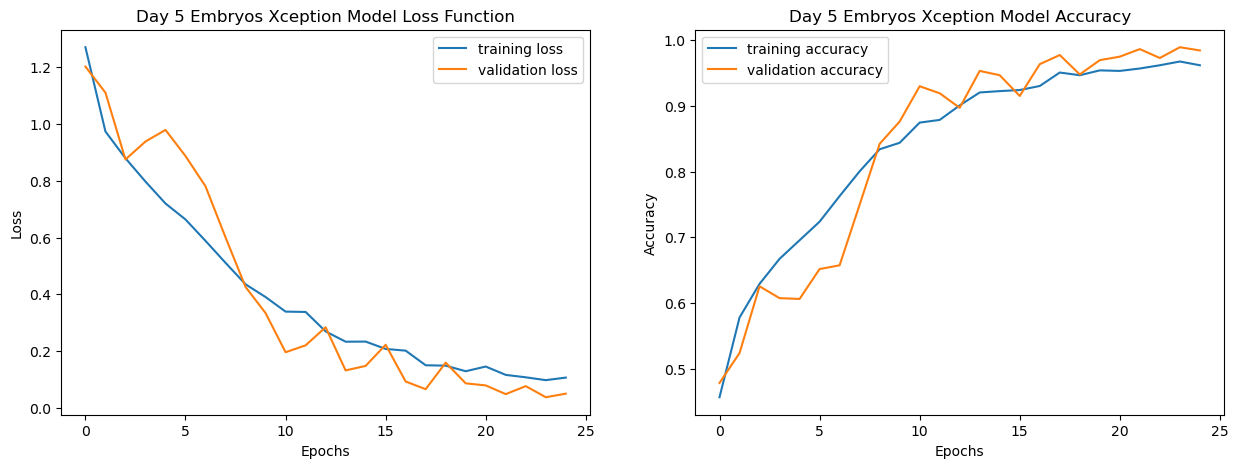

In [36]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Day 5 Embryos Xception Model Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Day 5 Embryos Xception Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Results/Day-5 Embryos-Xception-Model-Accuracy-Loss.png')
plt.legend();

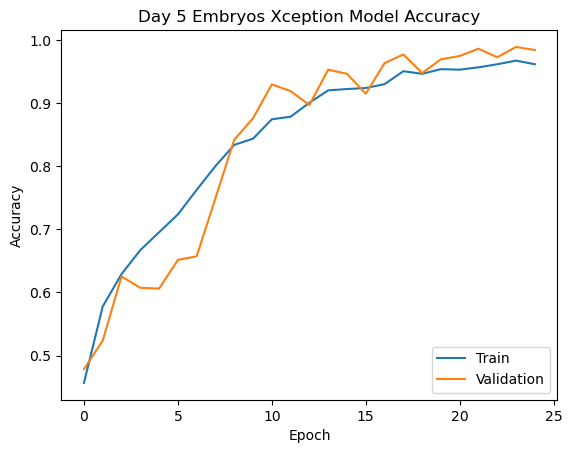

In [37]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Day 5 Embryos Xception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig('Results/Xception-Embryo-Accuracy-Comparison.png')
plt.show()

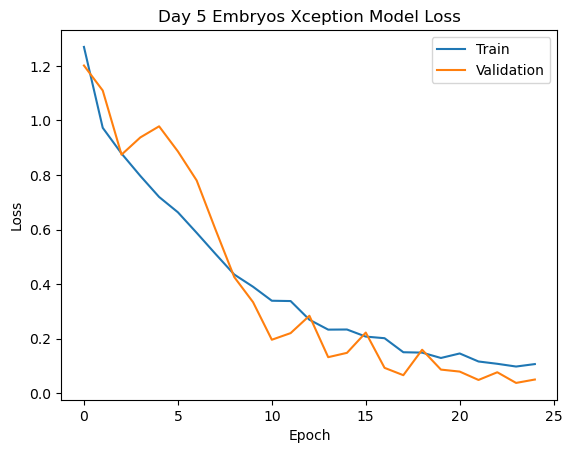

In [38]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Day 5 Embryos Xception Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.savefig('Results/Xception-Embryo-Loss-Comparison.png')
plt.show()

# Predicting Test Dataset

20/20 [==============================] - 7s 332ms/step


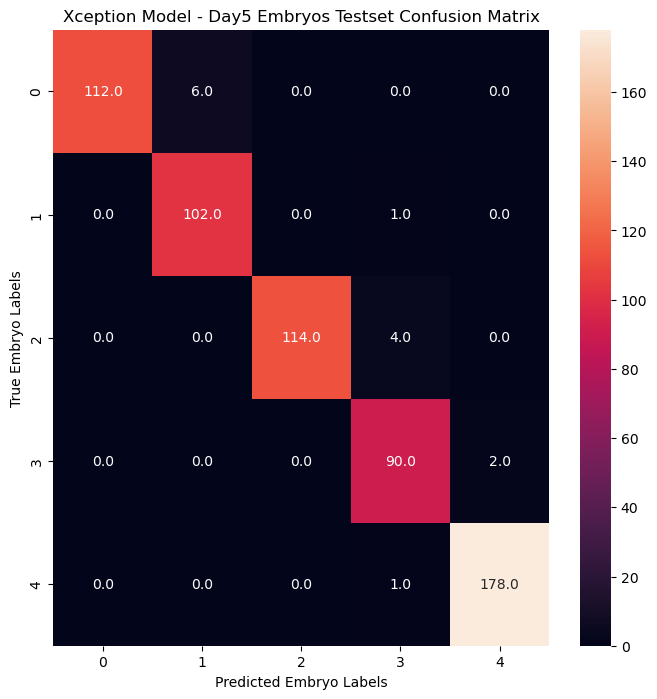

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = xception_model.predict(x_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# https://www.v7labs.com/blog/confusion-matrix-guide

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', xticklabels='auto', yticklabels='auto')
plt.xlabel('Predicted Embryo Labels')
plt.ylabel('True Embryo Labels')
plt.title('Xception Model - Day5 Embryos Testset Confusion Matrix')
plt.savefig('Results/Day5-Embryos-Xception-Model-Confusion-Matrix.png')
plt.show();

In [43]:
# Printing the model scores:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       118
           1       0.94      0.99      0.97       103
           2       1.00      0.97      0.98       118
           3       0.94      0.98      0.96        92
           4       0.99      0.99      0.99       179

    accuracy                           0.98       610
   macro avg       0.97      0.98      0.97       610
weighted avg       0.98      0.98      0.98       610



In [44]:
y_train_arg=np.argmax(y_train,axis=1)
yp_train = np.argmax(xception_model.predict(x_train),axis=1)
print('Train Confusion Matrix')
print(confusion_matrix(y_train_arg, yp_train))

52/52 [==============================] - 18s 352ms/step
Train Confusion Matrix
[[313  11   0   0   1]
 [  0 274   1   0   0]
 [  0   0 313   1   1]
 [  0   0   0 245   1]
 [  0   0   3   4 479]]


In [45]:
y_val_arg=np.argmax(y_val,axis=1)
yp_val = np.argmax(xception_model.predict(x_val),axis=1)
print('Val Confusion Matrix')
print(confusion_matrix(y_val_arg, yp_val))

6/6 [==============================] - 2s 338ms/step
Val Confusion Matrix
[[30  0  0  0  0]
 [ 0 33  0  0  0]
 [ 1  1 38  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 52]]


In [46]:
y_test_arg=np.argmax(y_test,axis=1)
yp_test = np.argmax(xception_model.predict(x_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, yp_test))

20/20 [==============================] - 7s 344ms/step
Confusion Matrix
[[112   6   0   0   0]
 [  0 102   0   1   0]
 [  0   0 114   4   0]
 [  0   0   0  90   2]
 [  0   0   0   1 178]]


# Model Evaluation

In [47]:
def evaluation_parametrics(name, y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train_arg, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    #s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train_arg, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train_arg, yp_train, average='micro'),4))
    #print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train_arg, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train_arg, yp_train, average='micro'),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train_arg, yp_train, average='micro'),4))
    # print("ROC AUC Score on Train Data: ", round(roc_auc_score(y_train_arg, yp_train,average='micro'),4))
    print("--------------------------------------------------------------------------")
    
    
    cm_val = confusion_matrix(y_val_arg, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    #s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val_arg, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val_arg, yp_val, average='micro'),4))
    #print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val_arg, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val_arg, yp_val, average='micro'),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val_arg, yp_val, average='micro'),4))
    print("--------------------------------------------------------------------------")


    cm_test = confusion_matrix(y_test_arg, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    #s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test_arg, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test_arg, yp_test, average='micro'), 4))
    #print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test_arg, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test_arg, yp_test, average='micro'), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test_arg, yp_test, average='micro'), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()
    t3.plot()

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score


-----------------------------Xception Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       325
           1       0.96      1.00      0.98       275
           2       0.99      0.99      0.99       315
           3       0.98      1.00      0.99       246
           4       0.99      0.99      0.99       486

    accuracy                           0.99      1647
   macro avg       0.98      0.99      0.99      1647
weighted avg       0.99      0.99      0.99      1647

--------------------------------------------------------------------------
Recall on Train Data:  0.986
Accuracy on Train Data:  0.986
Precision on Train Data:  0.986
F1 Score on Train Data:  0.986
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0     

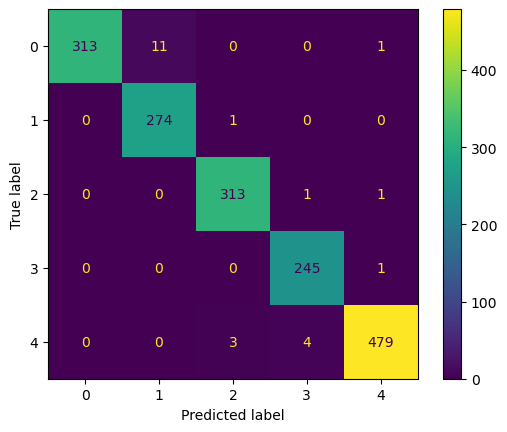

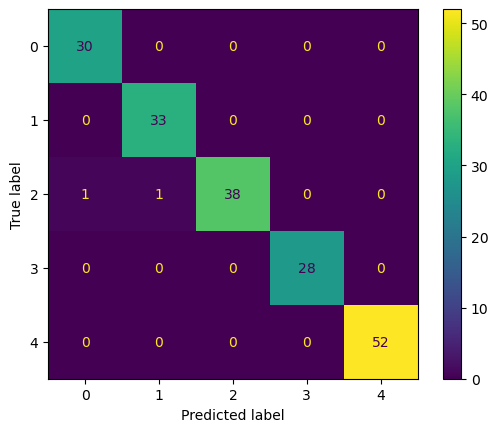

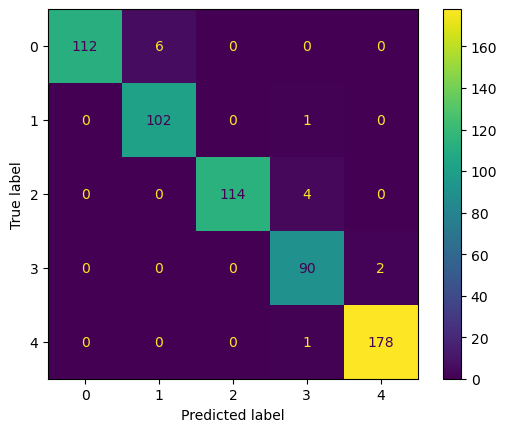

In [49]:
evaluation_parametrics("Xception Neural Network", y_train_arg, yp_train, y_val_arg, yp_val, y_test_arg, yp_test)

# ROC-AUC Analysis

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
#predict proba
y_proba = xception_model.predict_on_batch(x_test)

In [51]:
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_proba,
    multi_class="ovr",
    average="micro",
)
micro_roc_auc_ovr

0.9995928513840365

In [52]:
auc = metrics.roc_auc_score(y_test, y_proba)
auc

0.9997204043875334

# Image Analysis using Grad-CAM

In [68]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.savefig('Results/Xception-Day5-Embryos-Testset-Images-Heatmap-Analysis.png')
    plt.show()

Config- Parameters

In [69]:
# Grad-CAM

import keras
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ['data/ed4/alldata/1/20.png',
            'data/ed4/alldata/2/98.png',
            'data/ed4/alldata/3/47.png',
            'data/ed4/alldata/4/50.png',
            'data/ed4/alldata/5/127.png']

Grad - CAM Algorithm

In [70]:
# To Get Image into numpy array


def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = tf.keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Heatmap

In [71]:
# Storing Heatmap values into list

Xception_embryo_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    Xception_embryo_heatmap.append(heatmap)

1/1 [==============================] - 1s 751ms/step


Creating a Superimposed Viz

In [72]:
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], Xception_embryo_heatmap[i])

C:\Users\sbhum\AppData\Local\Temp\ipykernel_16760\3594932268.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


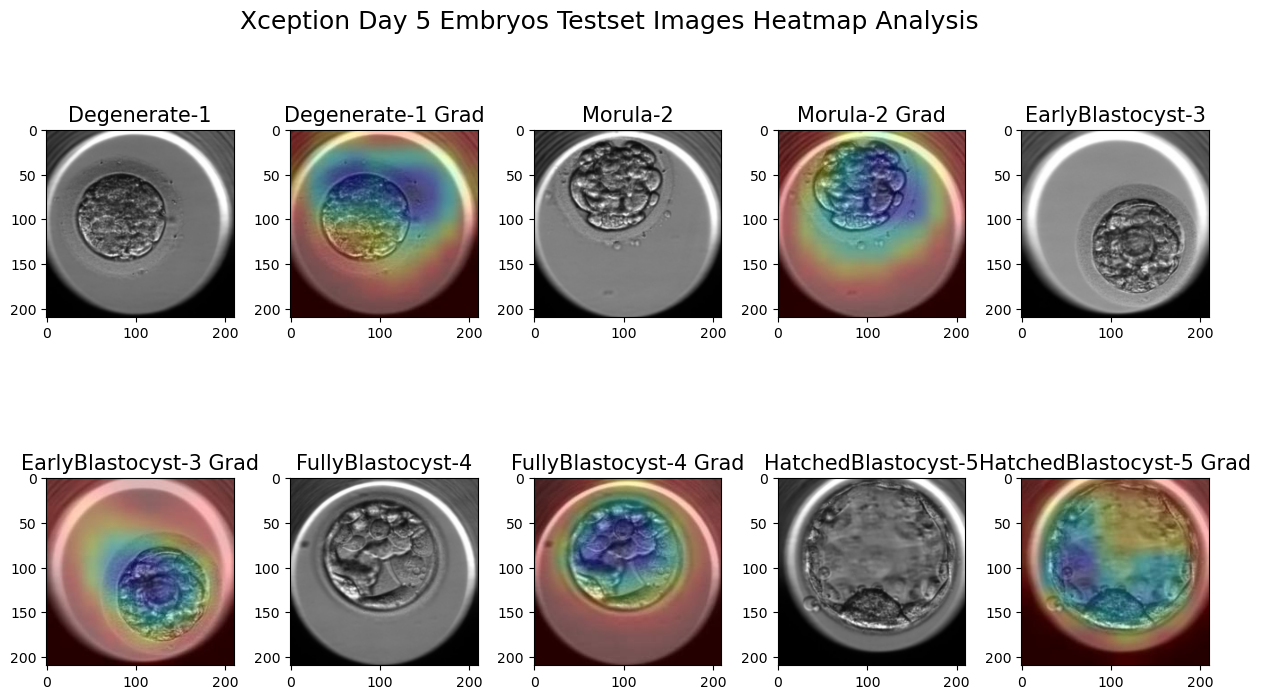

In [73]:

titles_list = ["Degenerate-1",'Degenerate-1 Grad','Morula-2','Morula-2 Grad','EarlyBlastocyst-3','EarlyBlastocyst-3 Grad','FullyBlastocyst-4','FullyBlastocyst-4 Grad', 'HatchedBlastocyst-5','HatchedBlastocyst-5 Grad']

plot_multiple_img(imag, titles_list, ncols = 5, main_title = "Xception Day 5 Embryos Testset Images Heatmap Analysis")

# Conclusion

Done Exploratory Image Data Analysis on Day 5 Blastocysts vs Non-Blastocysts Images using various techniques.

Applied ResNet-50 Convolutional Neural Network Model and got 98% Test Accuracy, 99% Test AUC, and 0.0535 Loss

Prevented Overfitting by applying Data Augmentation on Train Images Dataset

Applied Grad - CAM Analysis on Day 5 Embryos Test Images and found few insights.

# Test the Xception Model

In [74]:
#load model
from keras.models import load_model
loaded_xception_model=load_model("day5_embryo_xception_model.h5")

In [75]:
classes = [1, 2, 3, 4, 5]
IMG_SIZE = 128

def embryo_predict(imgfilepath):
    
    img_array = cv2.imread(imgfilepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE) )
    # Normalizing the image
    image=new_array/255.0
    prediction = loaded_xception_model.predict([image.reshape(-1, IMG_SIZE, IMG_SIZE, 3)])
    MaxPosition=np.argmax(prediction)  
    prediction_label=classes[MaxPosition]
    
    if prediction_label == 1:
        return "This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."
    elif prediction_label == 2:
        return "This Embryo is at the 'Morula' stage. More than 50% of the embryo has undergone compaction."
    elif prediction_label == 3:
        return "This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."
    elif prediction_label == 4:
        return "This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."
    elif prediction_label == 5:
        return "This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

In [77]:
embryo_predict('data/ed4/alldata/1/0.png')

1/1 [==============================] - 1s 794ms/step


"This Embryo is at the 'Degenerate' Embryo stage. Embryo failed to develop."

In [79]:
embryo_predict('data/ed4/alldata/2/40.png')

1/1 [==============================] - 0s 65ms/step


"This Embryo is at the 'Morula' stage. More than 50% of the embryo has undergone compaction."

In [80]:
embryo_predict('data/ed4/alldata/3/126.png')

1/1 [==============================] - 0s 81ms/step


"This Embryo is at the 'Early Blastocyst' stage. Balstocoele less than the volume of the embryo."

In [81]:
embryo_predict('data/ed4/alldata/4/300.png')

1/1 [==============================] - 0s 77ms/step


"This Embryo is at the 'Full Blastocyst' stage. Blastocoele completely filling embryo."

In [82]:
embryo_predict('data/ed4/alldata/5/700.png')

1/1 [==============================] - 0s 66ms/step


"This Embryo is at the 'Hatched Blastocyst' stage. Blastocysts completely hatched."

# ROC AUC curves

In [85]:
# Predicting labels from X_test data
y_pred = loaded_xception_model.predict(x_test)

20/20 [==============================] - 7s 320ms/step


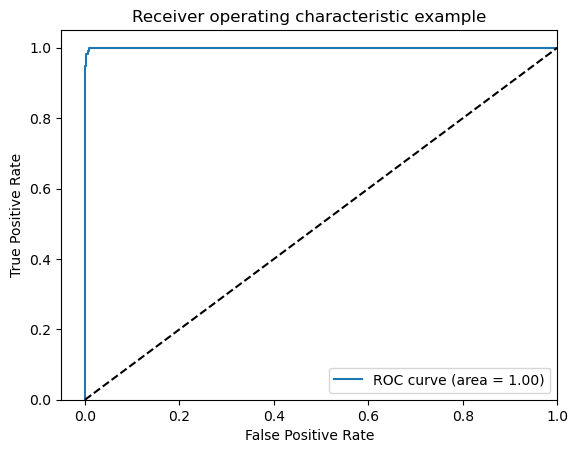

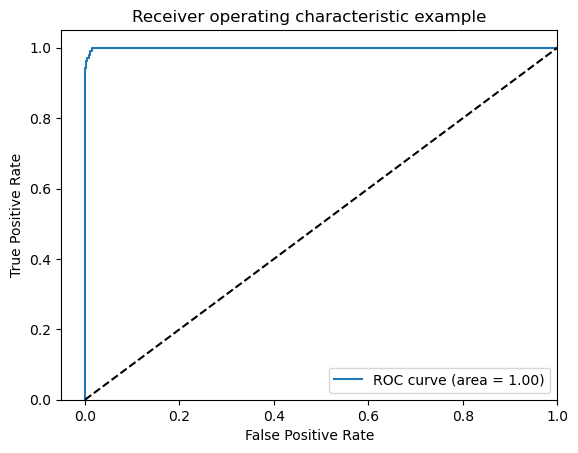

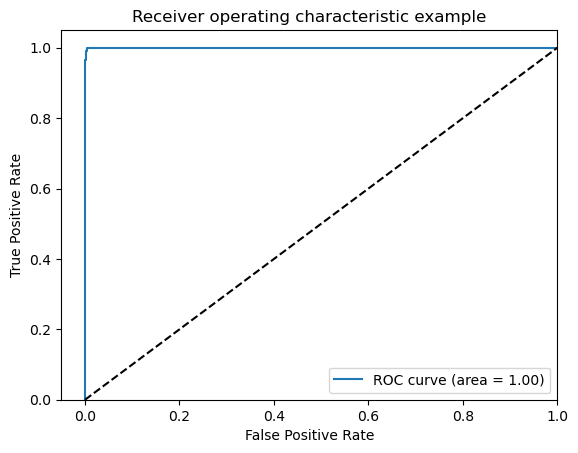

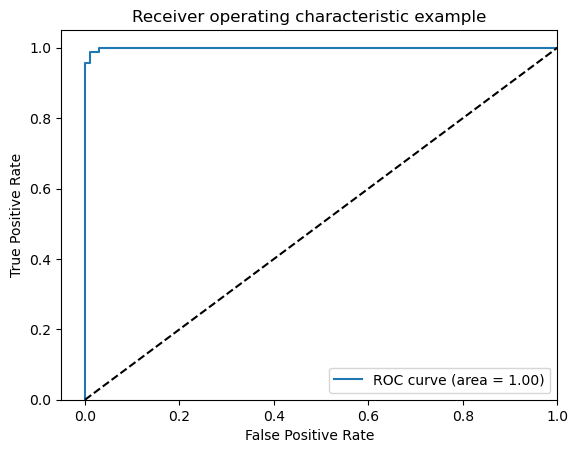

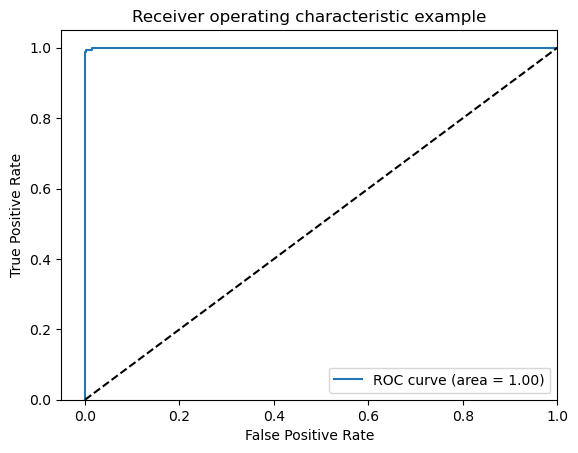

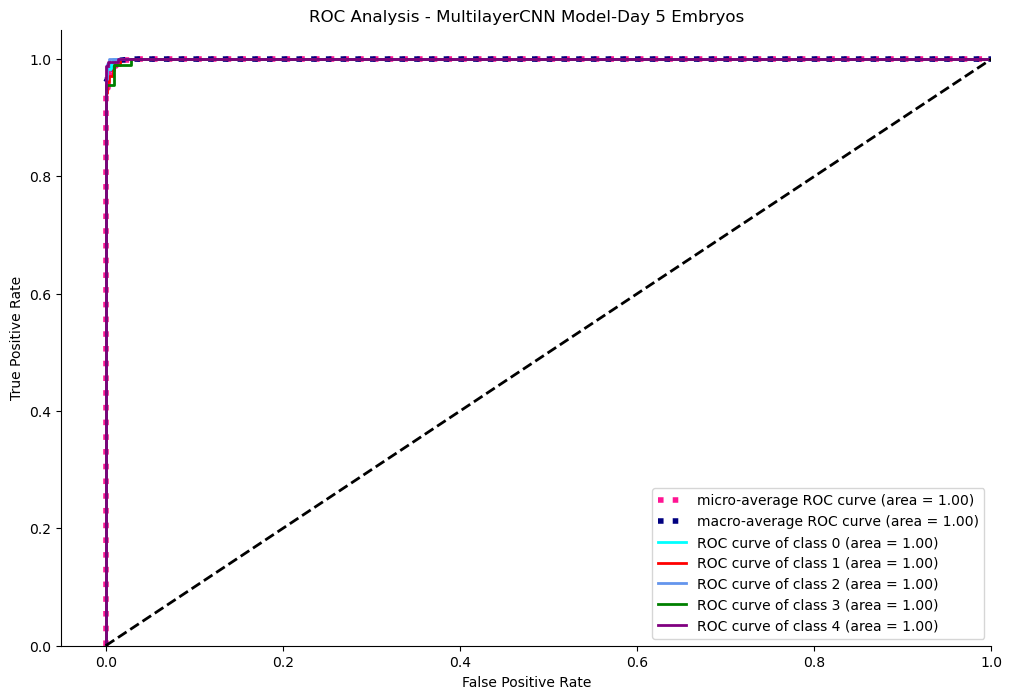

In [86]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#y_test = np.array(y_test)

n_classes = 5


# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'red', 'cornflowerblue', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis - MultilayerCNN Model-Day 5 Embryos')
plt.legend(loc="lower right")
sns.despine()
plt.savefig('Results/ROC-AUC-MultilayerCNN-Day5-Embryo-graph.png')
plt.show()